# Compare empirical vs. simulation rainfall C.V.

Originally, I plotted up the distributions of 10,000 simulations vs. 80 years of data so we had a sample size problem. Below, I compare rainfall from empirical data vs. simulation data with comparable sample sizes by resampling the simulation data. The end goal is to see whether the C.V.s of the two sources of rainfall data are similar.

Different things we tried:

1. New method for calculating lambdas (do_std = True)
    - [Ol Jogi: Full years worth of rainfall](#365_OlJogi)
    - [Ol Jogi: MAM rainfall](#mam_OlJogi)
    - [Jacobson Farm: Full years](#365_JF)
    - [Jacobson Farm: MAM rainfall](#mam_JF)
2. Old method where lambdas does not vary
    - [Jacobson Farm: MAM rainfall](#MAM_Jacobson)
3. Make a different plot of CV
    - [Im not sure this is right](#scatter)
    
Did this all for 'average' lambda and alpha conditions. Could also break up by three eras.

Last updated: 5 November 2020

In [1]:
## We need to add the module path to our system path so 
## so that our notebook can find our local objects and code:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
     
# import packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from math import exp
import seaborn as sns
import sys
import glob
from dateutil.relativedelta import *
from numpy.random import exponential, uniform
import scipy.stats as st

# import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import CropModel
from farm.functions import *

# set background color
plot.rc['figure.facecolor'] = 'white'
plot.rc.axesfacecolor = 'white'

### Functions

Import empirical rainfall data

In [2]:
def grab_rf_data(station=None, data_file=None):
    """ Grabs the rainfall data from the CETRAD data file for a specific station.
    
    Usage:
        grab_rf_data(station, data_file)
        
        station = 'Jacobson Farm' # string
        data_file = "../data/CETRAD/CETRAD_rainfall.csv" # path_to_file
        
    Note: This will only work for Laikipia stations
    """
    station=station
    data_file=data_file

    # Prepare the CETRAD dataset.
    df = pd.read_csv(data_file)  # Read in the raw csv data.

    # Step 1. Convert text strings into datetime objects.
    format = '%m/%d/%y' # Column RDate has data in M/D/YY
    df['Datetime']=pd.to_datetime(df['RDate'], format=format) # Create a new column of datetime objects using RDate.

    # 2. Step 2. Convert future dates inferred during the conversion back into 20th century dates.
    # Python is a future-looking programming language, and assumes that 1/1/34 is Jan 1, 2034.
    # We can fix this by finding all the dates in the future (dt > datetime.now()) and removing 100 years from
    # their value. This requires using the relativedelta function, which handles weird stuff like leap years.
    df['Datetime'] = df['Datetime'].map(lambda dt: dt+relativedelta(years=-100) if dt > datetime.now() else dt)

    # Step 3. Extract the Year and Month from the Datetime to make aggregation easier.
    df['Year'] = [dt.year for dt in df['Datetime']]
    df['Month'] = [dt.month for dt in df['Datetime']]
    df['Week'] = [dt.week for dt in df['Datetime']]
    df['Dekad'] = df['Datetime'].dt.dayofyear//10+1

    n_years = len(df['Year'].unique())

    # Step 4. Use the Datetime values as the index for this dataframe.
    df = df.set_index(pd.DatetimeIndex(df['Datetime']))  # Set the Datetime column as the dataframe index

    # Step 5.  Delete the old RDate column, which we no longer need. 
    # We will keep the Datetime column, in case we need it later.
    df = df.drop(['RDate'], axis=1)

    columns = [station] + ['Year', 'Month', 'Week', 'Dekad', 'Datetime']
    rainfall = df[columns]
    return rainfall.dropna()

def plot_cvs(cvs = None, ylabel='C.V.', xlabel='Sample number'):
    plt.scatter(np.arange(0, n), np.sort(cvs))
    #plt.plot(np.sort(cvs))
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    return pd.DataFrame(cvs).describe()

## Annual rainfall for Ol Jogi Farm <a id='365_OlJogi'></a>

### Import simulation rainfall data

In [3]:
# Import in the data
n_sim = 10000
no_sims = np.arange(0,n_sim)

#files = glob.glob('../output/results_10262020/full_year/*.csv') # new lambdas
files = glob.glob('../output/high-res-figures/sims/*.csv') # new lambdas # this is not a full year

output = []
for f, n in zip(files, no_sims):
    f_ = pd.read_csv(f).drop('Unnamed: 0',axis=1)
    output.append(f_)

output[99]
len(output) # Check that there are 10,000 seasons

10000

In [4]:
output_rf = np.array([df['R'].sum() for df in output])

# So this is the annual rainfall for 10,000 simulations. Normal or "average" dekad and lambda values.
sims_rf = output_rf

### Let's get annual rainfall for Ol Jogi Farm (empirical)

In [5]:
# Let's get annual rainfall from empirical data
rf = grab_rf_data(station='OL JOGI FARM', data_file="../data/CETRAD/CETRAD_rainfall.csv")
rf_OlJogi = rf.groupby(['Year'])['OL JOGI FARM'].sum().to_frame()

# Some of these look like they may have incomplete records

In [6]:
emp_rf = rf_OlJogi['OL JOGI FARM'].values

print('heres the simulation rainfall for Ol Jogi', sims_rf)
print('heres the empirical rainfall for Ol Jigi', emp_rf) # that last value doesnt seem right 

heres the simulation rainfall for Ol Jogi [213.11557247 223.87838027 457.11816339 ... 269.69288769 161.24088407
 343.91305252]
heres the empirical rainfall for Ol Jigi [ 860.8   683.    427.6   448.1   524.6   622.2   318.2   378.9   673.
  429.1   776.3   557.6   498.4   245.6   722.7   575.5   758.    187.5
  395.5   670.    356.    850.    610.    696.    237.2   426.    359.2
  574.3   631.2   365.15 1124.6   664.  ]


We want to compare the same number of values for th empirical and simulation data. Currently the sample sizes are very different:

In [7]:
print(len(sims_rf), len(emp_rf))

10000 32


So we need to sample 33 values from the simulation data. Calculate C.V. and then run this 1k times and see if the values converge

,0
count,1000.000000
mean,0.414432
std,0.062601
min,0.256205
25%,0.372448
50%,0.411285
75%,0.449828
max,0.621459


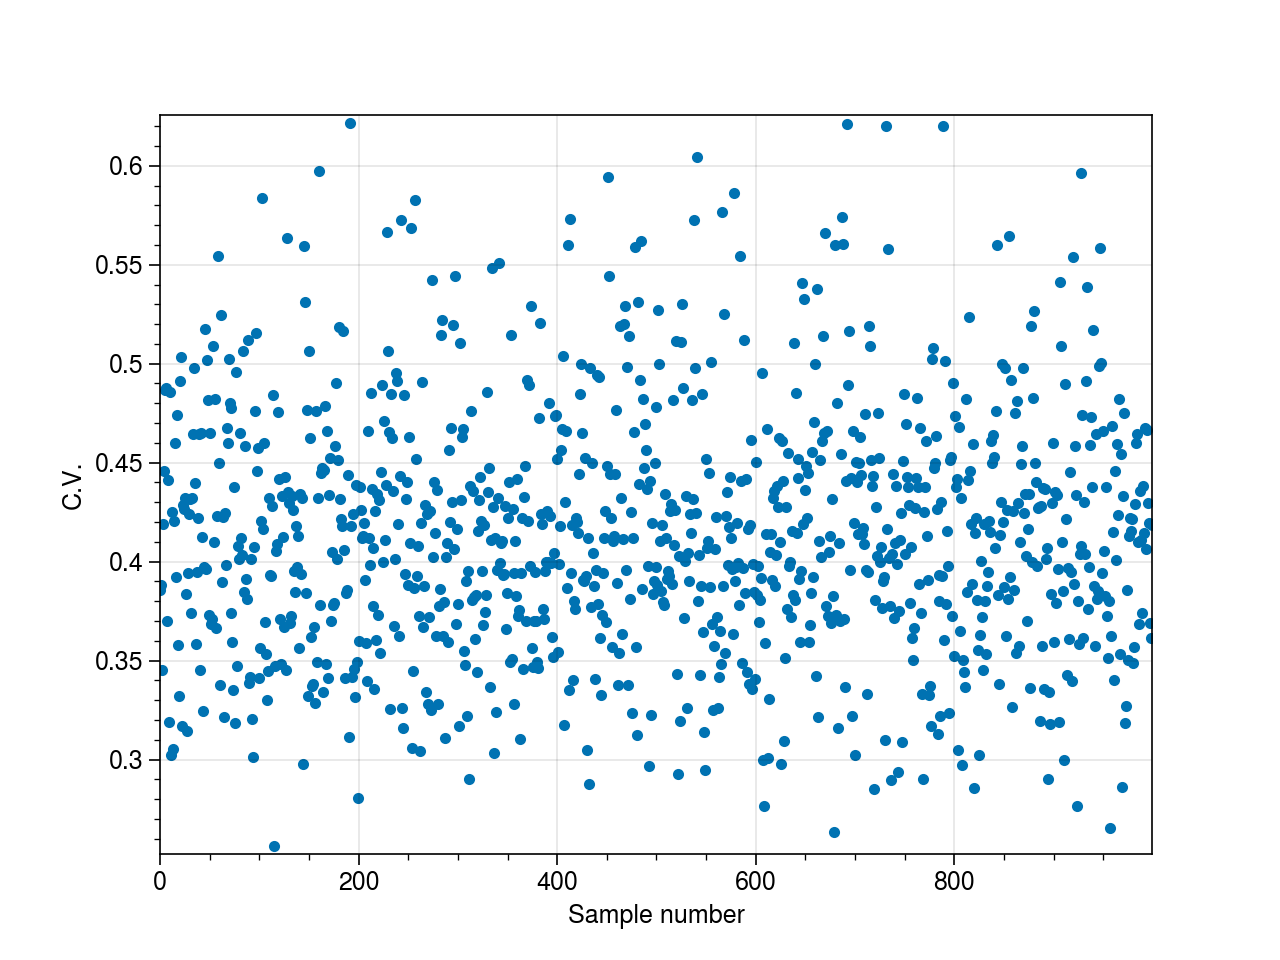

In [8]:
n = 1000
n_sample = len(emp_rf)

# Let's see how this works to get 33 samples from simulation data
samp_rf = pd.DataFrame(sims_rf).sample(n=n_sample)
#print(samp_rf)

# Get C.V.s of sampled simulation data
cvs = [pd.DataFrame(sims_rf).sample(n=n_sample).std()
       /pd.DataFrame(sims_rf).sample(n=n_sample).mean() for n in range(n)]

plt.xlabel('Sample number')
plt.ylabel('C.V.')
pd.DataFrame(cvs).describe()

plot_cvs(cvs=cvs)

Here are the statistics for all of the samples:

In [9]:
# Make a table comparing the CVs of the sampled values compared to the empirical
table = pd.DataFrame({
            'Source':['Simulations','Empirical'],
            'Average':[sims_rf.mean(), emp_rf.mean()],
            'Standard Deviation':[sims_rf.std(), emp_rf.std()],
            'CV':[sims_rf.std()/sims_rf.mean(), emp_rf.std()/emp_rf.mean()],
            'No. in Sample':[len(sims_rf),
                       len(emp_rf)]})

table

,Source,Average,Standard Deviation,CV,No. in Sample
0,Simulations,352.989252,145.590626,0.412451,10000
1,Empirical,551.445312,204.243492,0.370379,32


/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


32 32


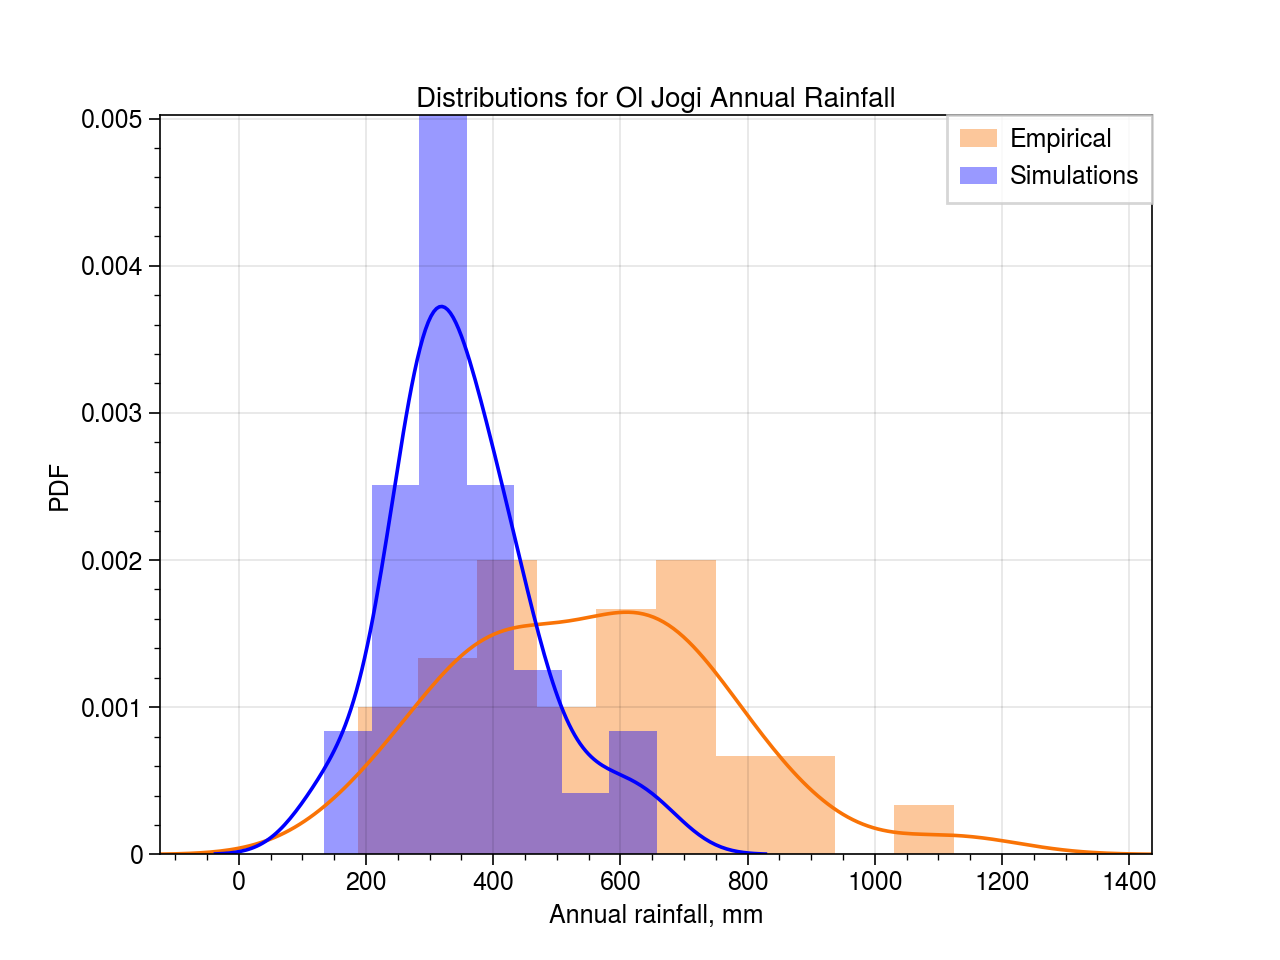

In [10]:
# Let's plot the sampled rainfall (from simulations) versus the empirical

# Get the n values
#sns.displot(samp_rf[0], label="Simulations") # "avg" # bw=.2
#sns.kdeplot(emp_rf, label="Empirical", cut=0) # clip=(0,1000
sns.distplot(emp_rf, label="Empirical", color='orange', bins=10)
sns.distplot(samp_rf[0], label="Simulations", color='blue')

plt.title('Distributions for Ol Jogi Annual Rainfall')
plt.ylabel('PDF')
plt.xlabel('Annual rainfall, mm')
plt.legend();

print(len(emp_rf), len(samp_rf[0]))

## MAM rainfall for Ol Jogi <a id='mam_OlJogi'></a>


In [11]:
# Get the MAM rainfall from the empirical data
_rf = rf.groupby(['Year','Month'])['OL JOGI FARM'].sum().to_frame().reset_index()
months = [3,4,5]
rf_mam = _rf[_rf.Month.isin(months)]
rf_mam = rf_mam.groupby(['Year'])['OL JOGI FARM'].sum().to_frame()
emp_rf = rf_mam['OL JOGI FARM'].values

# Get the MAM rainfall from the simulations
# day 60-151 is March 1 to May 31
output_rf = np.array([df['R'][59:151].sum() for df in output])
sims_rf = output_rf


,Source,Average,Standard Deviation,CV,No. in Sample
0,Simulations,193.975833,88.347577,0.455457,10000
1,Empirical,213.518750,96.630063,0.452560,32


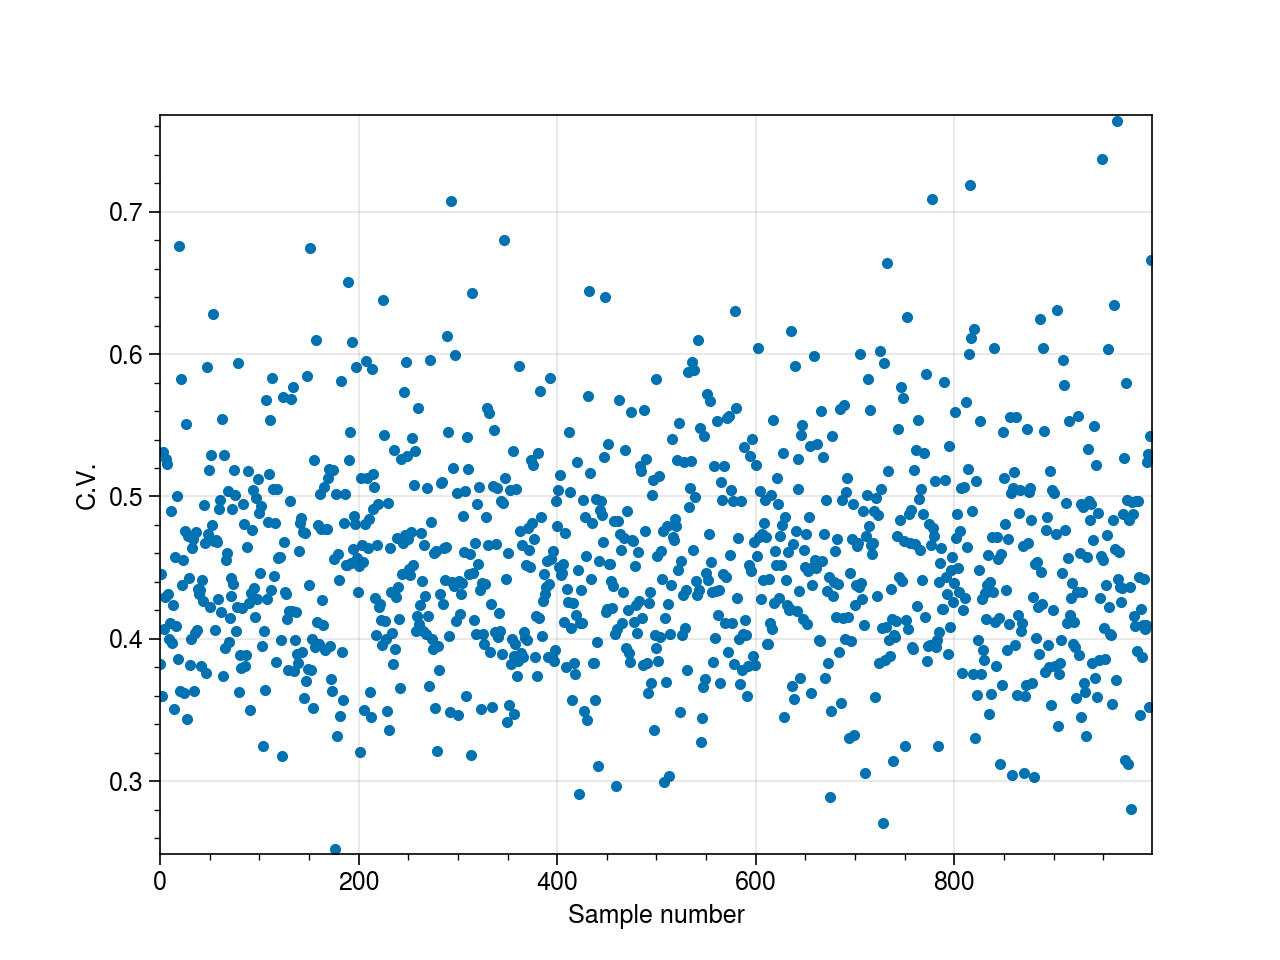

In [12]:
# Get 33 samples from simulations
n = 1000
n_sample = len(emp_rf)

# Let's see how this works to get 33 samples from simulation data
samp_rf = pd.DataFrame(sims_rf).sample(n=n_sample)
#print(samp_rf)

# Get C.V.s of sampled simulation data
cvs = [pd.DataFrame(sims_rf).sample(n=n_sample).std()
       /pd.DataFrame(sims_rf).sample(n=n_sample).mean() for n in range(n)]

plt.xlabel('Sample number')
plt.ylabel('C.V.')
pd.DataFrame(cvs).describe()

plot_cvs(cvs=cvs)

# Make a table comparing the CVs of the sampled values compared to the empirical
table = pd.DataFrame({
            'Source':['Simulations','Empirical'],
            'Average':[sims_rf.mean(), emp_rf.mean()],
            'Standard Deviation':[sims_rf.std(), emp_rf.std()],
            'CV':[sims_rf.std()/sims_rf.mean(), emp_rf.std()/emp_rf.mean()],
            'No. in Sample':[len(sims_rf),
                       len(emp_rf)]})

table

/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


32 32


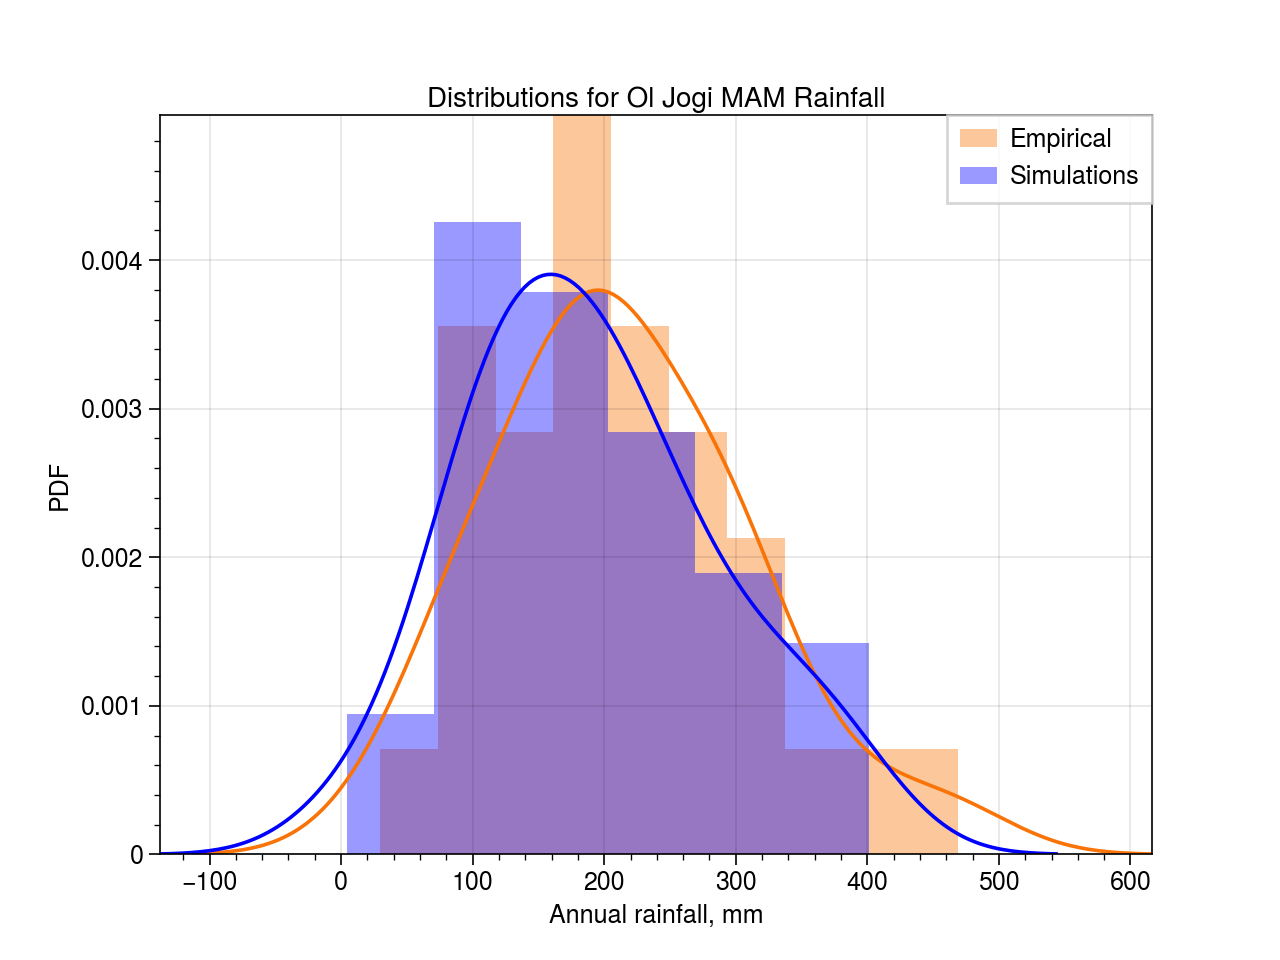

In [13]:
# Let's plot the sampled rainfall (from simulations) versus the empirical
sns.distplot(emp_rf, label="Empirical", color='orange', bins=10)
sns.distplot(samp_rf[0], label="Simulations", color='blue')

plt.title('Distributions for Ol Jogi MAM Rainfall')
plt.ylabel('PDF')
plt.xlabel('Annual rainfall, mm')
plt.legend();

print(len(emp_rf), len(samp_rf[0]))

## Annual rainfall for Jacobson Farm <a id='365_JF'></a>

In [3]:
# Import in the data
n_sim = 10000
no_sims = np.arange(0,n_sim)

#files = glob.glob('../output/final/full_year/*.csv') # old lambdas
files = glob.glob('../output/results_11042020/full_year/*.csv') # new lambdas

output = []
for f, n in zip(files, no_sims):
    f_ = pd.read_csv(f).drop('Unnamed: 0',axis=1)
    output.append(f_)

output[99]
len(output) # Check that there are 10,000 seasons

10000

In [4]:
output_rf = np.array([df['R'].sum() for df in output])

# So this is the annual rainfall for 10,000 simulations. Normal or "average" dekad and lambda values.
sims_rf = output_rf

### Let's get annual rainfall for Jacobson Farm (empirical)

In [5]:
# Let's get annual rainfall from empirical data
rf = grab_rf_data(station='JACOBSON FARM', data_file="../data/CETRAD/CETRAD_rainfall.csv")
rf_OlJogi = rf.groupby(['Year'])['JACOBSON FARM'].sum().to_frame()

# Some of these look like they may have incomplete records

In [6]:
emp_rf = rf_OlJogi['JACOBSON FARM'].values

print('heres the simulation rainfall for JF', sims_rf)
print('heres the empirical rainfall for JF', emp_rf) # that last value doesnt seem right 

emp_rf = emp_rf[:-1] # if going to remove this need to do it sooner because rainfall lambdas is based on this

heres the simulation rainfall for JF [570.60367175 784.93821227 582.57434512 ... 626.27311724 611.10603692
 788.43471212]
heres the empirical rainfall for JF [ 419.9       773.7       895.1       748.7       694.2       518.
  744.        757.9       690.6       584.6       661.7       555.3
  442.1       832.4       779.3       645.1       661.9      1047.4
  672.9       637.7       835.9       828.9       855.2       771.1
  840.2       687.9       715.6      1144.6       799.6      1066.8
  961.1       503.        760.3       720.1       985.9       829.6
  526.1       718.7       589.2       514.1       701.2       781.1
  742.9       860.2       730.5       811.4       474.2       768.4
  587.4       804.        483.1       692.1       803.2       710.3
  825.9       912.4       860.7       609.3       604.1       693.5
  858.5       967.        696.722    1165.606     768.858     615.188
  464.3628    757.428     967.428     845.3       733.        685.00007
  767.000066  800.000

We want to compare the same number of values for th empirical and simulation data. Currently the sample sizes are very different:

In [7]:
print(len(sims_rf), len(emp_rf))

10000 81


So we need to sample 33 values from the simulation data. Calculate C.V. and then run this 1k times and see if the values converge

,0
count,1000.000000
mean,0.332396
std,0.027818
min,0.244165
25%,0.313781
50%,0.331225
75%,0.350436
max,0.472714


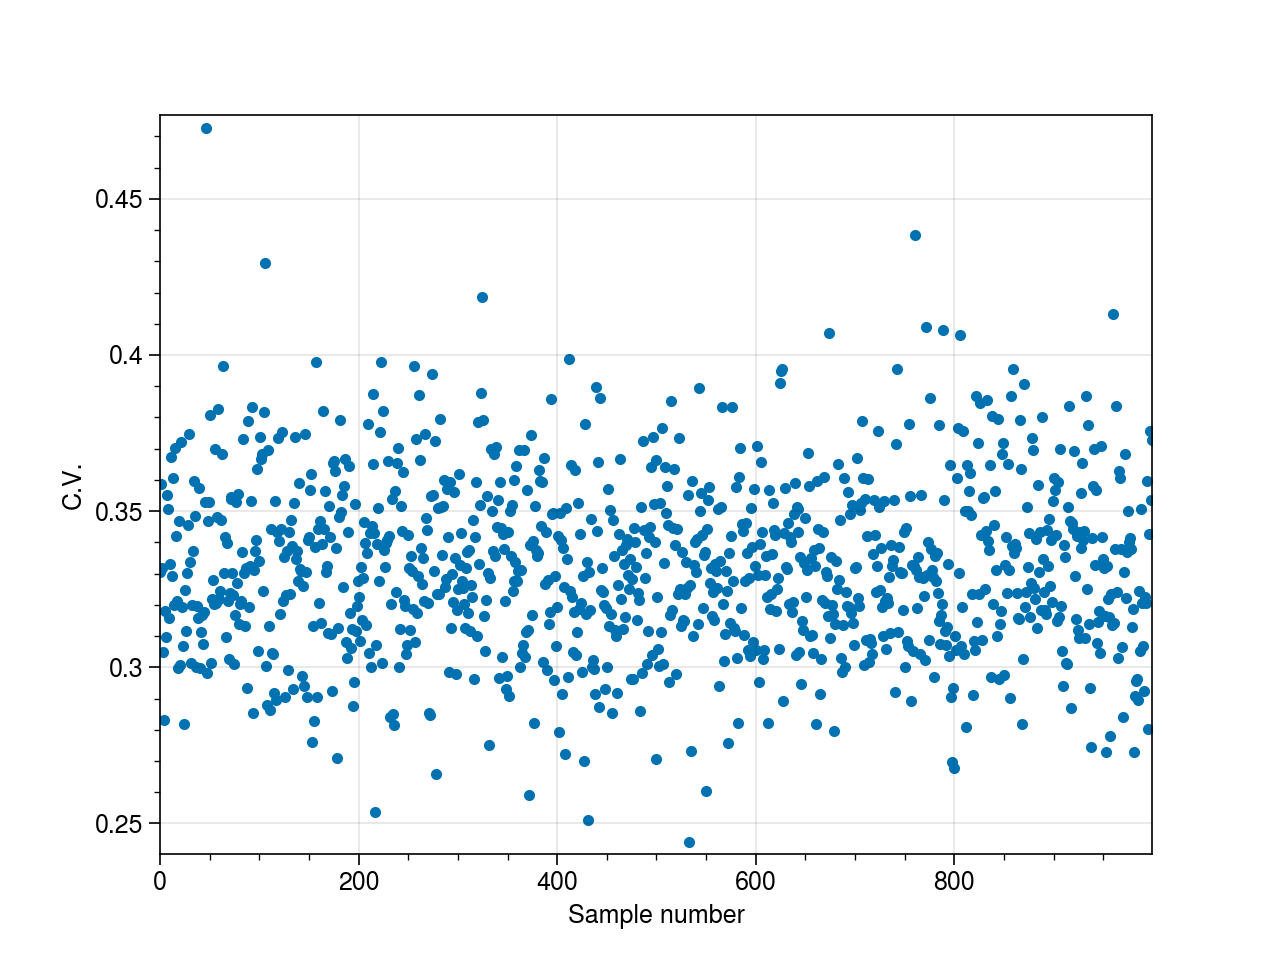

In [8]:
n = 1000
n_sample = len(emp_rf)

# Let's see how this works to get 33 samples from simulation data
samp_rf = pd.DataFrame(sims_rf).sample(n=n_sample)
#print(samp_rf)

# Get C.V.s of sampled simulation data
cvs = [pd.DataFrame(sims_rf).sample(n=n_sample).std()
       /pd.DataFrame(sims_rf).sample(n=n_sample).mean() for n in range(n)]

plt.xlabel('Sample number')
plt.ylabel('C.V.')
pd.DataFrame(cvs).describe()

plot_cvs(cvs=cvs)

Here are the statistics for all of the samples:

In [9]:
# Make a table comparing the CVs of the sampled values compared to the empirical
table = pd.DataFrame({
            'Source':['Simulations','Empirical'],
            'Average':[sims_rf.mean(), emp_rf.mean()],
            'Standard Deviation':[sims_rf.std(), emp_rf.std()],
            'CV':[sims_rf.std()/sims_rf.mean(), emp_rf.std()/emp_rf.mean()],
            'No. in Sample':[len(sims_rf),
                       len(emp_rf)]})

table

,Source,Average,Standard Deviation,CV,No. in Sample
0,Simulations,664.565159,221.477233,0.333266,10000
1,Empirical,744.008562,154.002541,0.206990,81


/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


81 81


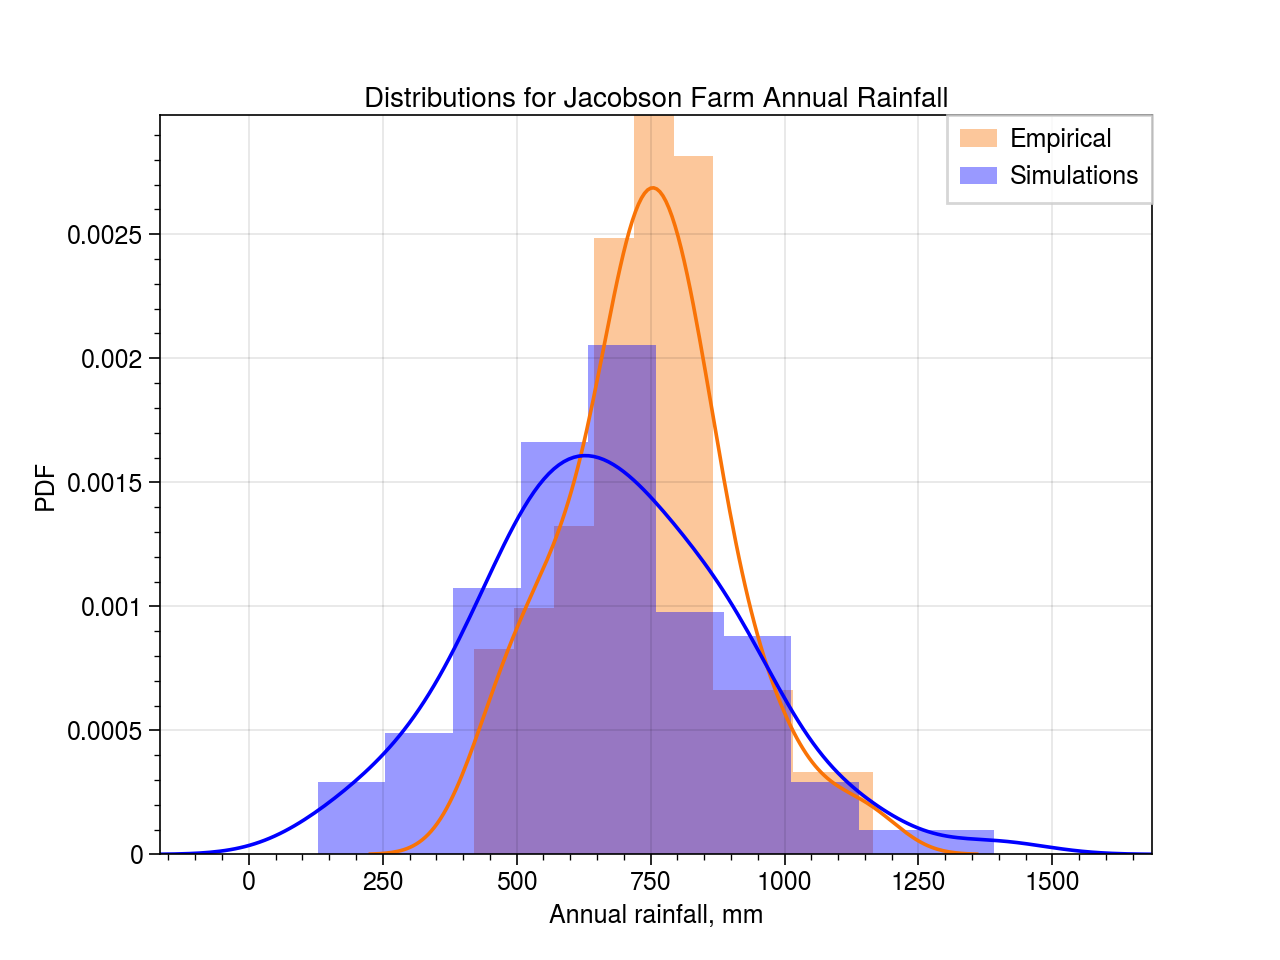

In [10]:
# Let's plot the sampled rainfall (from simulations) versus the empirical

# Get the n values
#sns.displot(samp_rf[0], label="Simulations") # "avg" # bw=.2
#sns.kdeplot(emp_rf, label="Empirical", cut=0) # clip=(0,1000
sns.distplot(emp_rf, label="Empirical", color='orange', bins=10)
sns.distplot(samp_rf[0], label="Simulations", color='blue')

plt.title('Distributions for Jacobson Farm Annual Rainfall')
plt.ylabel('PDF')
plt.xlabel('Annual rainfall, mm')
plt.legend();

print(len(emp_rf), len(samp_rf[0]))

## MAM rainfall for Jacobson Farm <a id='mam_JF'></a>


In [ ]:
# Get the MAM rainfall from the empirical data
_rf = rf.groupby(['Year','Month'])['JACOBSON FARM'].sum().to_frame().reset_index()
months = [3,4,5]
rf_mam = _rf[_rf.Month.isin(months)]
rf_mam = rf_mam.groupby(['Year'])['JACOBSON FARM'].sum().to_frame()
emp_rf = rf_mam['JACOBSON FARM'].values

# Get the MAM rainfall from the simulations
# day 60-151 is March 1 to May 31
output_rf = np.array([df['R'][59:151].sum() for df in output])
sims_rf = output_rf


In [ ]:
# Get 33 samples from simulations
n = 1000
n_sample = len(emp_rf)

# Let's see how this works to get 33 samples from simulation data
samp_rf = pd.DataFrame(sims_rf).sample(n=n_sample)
#print(samp_rf)

# Get C.V.s of sampled simulation data
cvs = [pd.DataFrame(sims_rf).sample(n=n_sample).std()
       /pd.DataFrame(sims_rf).sample(n=n_sample).mean() for n in range(n)]

plt.xlabel('Sample number')
plt.ylabel('C.V.')
pd.DataFrame(cvs).describe()

plot_cvs(cvs=cvs)

# Make a table comparing the CVs of the sampled values compared to the empirical
table = pd.DataFrame({
            'Source':['Simulations','Empirical'],
            'Average':[sims_rf.mean(), emp_rf.mean()],
            'Standard Deviation':[sims_rf.std(), emp_rf.std()],
            'CV':[sims_rf.std()/sims_rf.mean(), emp_rf.std()/emp_rf.mean()],
            'No. in Sample':[len(sims_rf),
                       len(emp_rf)]})

table

In [ ]:
# Let's plot the sampled rainfall (from simulations) versus the empirical

# Get the n values
#sns.displot(samp_rf[0], label="Simulations") # "avg" # bw=.2
#sns.kdeplot(emp_rf, label="Empirical", cut=0) # clip=(0,1000
sns.distplot(emp_rf, label="Empirical", color='orange', bins=10)
sns.distplot(samp_rf[0], label="Simulations", color='blue')

plt.title('Distributions for Jacobson MAM Rainfall')
plt.ylabel('PDF')
plt.xlabel('Annual rainfall, mm')
plt.legend();

print(len(emp_rf), len(samp_rf[0]))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

## Other scatterplot of CV <a id='scatter'></a>

Not sure that the steps of binning into 50 mm incremements is what I need to do

#### Step 1: Bin into 50 mm increments

In [15]:
# Define variables
texture = 'clay loam'
lgp = 180
soil = Soil(texture=texture)
crop = Crop(soil=soil, lgp=lgp)
soil.set_nZr(crop)

# Generate end of season yield, total rainfall from output
data = [crop.calc_dstress(s=df.s, stress=df.stress) for df in output] 
RF = [df['R'].sum() for df in output]
df = pd.DataFrame.from_records(data, columns =['AvgStress','DynamicStress','Yield'])
df['RF'] = RF
print(max(df.Yield)/1000)

2.4266568356383105


In [16]:
# roughly how many groups if in 50 mm incremements?
print((max(RF) - min(RF))/50)

result = pd.DataFrame(RF)
result['RF_bins'] = pd.cut(RF,12)
#result['RF_bins'] = pd.cut(RF,12, labels=labels)

result.RF_bins.value_counts()

# I dont think this is right

31.39803555650471


(523.301, 654.126]      2235
(654.126, 784.951]      2186
(392.475, 523.301]      1611
(784.951, 915.776]      1564
(915.776, 1046.601]      856
(261.65, 392.475]        791
(1046.601, 1177.426]     326
(130.825, 261.65]        258
(1177.426, 1308.251]     107
(-1.57, 130.825]          37
(1308.251, 1439.077]      25
(1439.077, 1569.902]       4
Name: RF_bins, dtype: int64

#### Step 2. Calculate cv of those rainfall bins

In [17]:
cv = result.groupby(['RF_bins'])[0].std() / result.groupby(['RF_bins'])[0].mean(); print(cv)
cv_dict = cv.to_dict()

RF_bins
(-1.57, 130.825]        0.669719
(130.825, 261.65]       0.175775
(261.65, 392.475]       0.112448
(392.475, 523.301]      0.080052
(523.301, 654.126]      0.064474
(654.126, 784.951]      0.051104
(784.951, 915.776]      0.043686
(915.776, 1046.601]     0.038533
(1046.601, 1177.426]    0.031480
(1177.426, 1308.251]    0.027772
(1308.251, 1439.077]    0.024930
(1439.077, 1569.902]    0.034888
Name: 0, dtype: float64


#### Step 3. Plot crop failure as a function of cv

In [18]:
# Map cv onto dataframe
df['cv_bin'] = df['RF'].map(cv_dict)

# Take only instances where crop failed
df_fail = df.loc[df['Yield'] == 0]

# For a given cv, get percentage of times the crop failed
df

,AvgStress,DynamicStress,Yield,RF,cv_bin
0,0.462617,0.685051,1341.682246,570.603672,0.064474
1,0.382379,0.745505,1084.148972,784.938212,0.051104
2,0.522326,1.000000,0.000000,582.574345,0.064474
3,0.410823,0.765240,1000.078193,839.209696,0.043686
4,0.537648,0.742413,1097.321928,507.779778,0.080052
...,...,...,...,...,...
9995,0.456086,0.810415,807.632802,838.887040,0.043686
9996,0.845731,1.000000,0.000000,159.732956,0.175775
9997,0.484878,0.678069,1371.425216,626.273117,0.064474
9998,0.531690,0.852866,626.789104,611.106037,0.064474


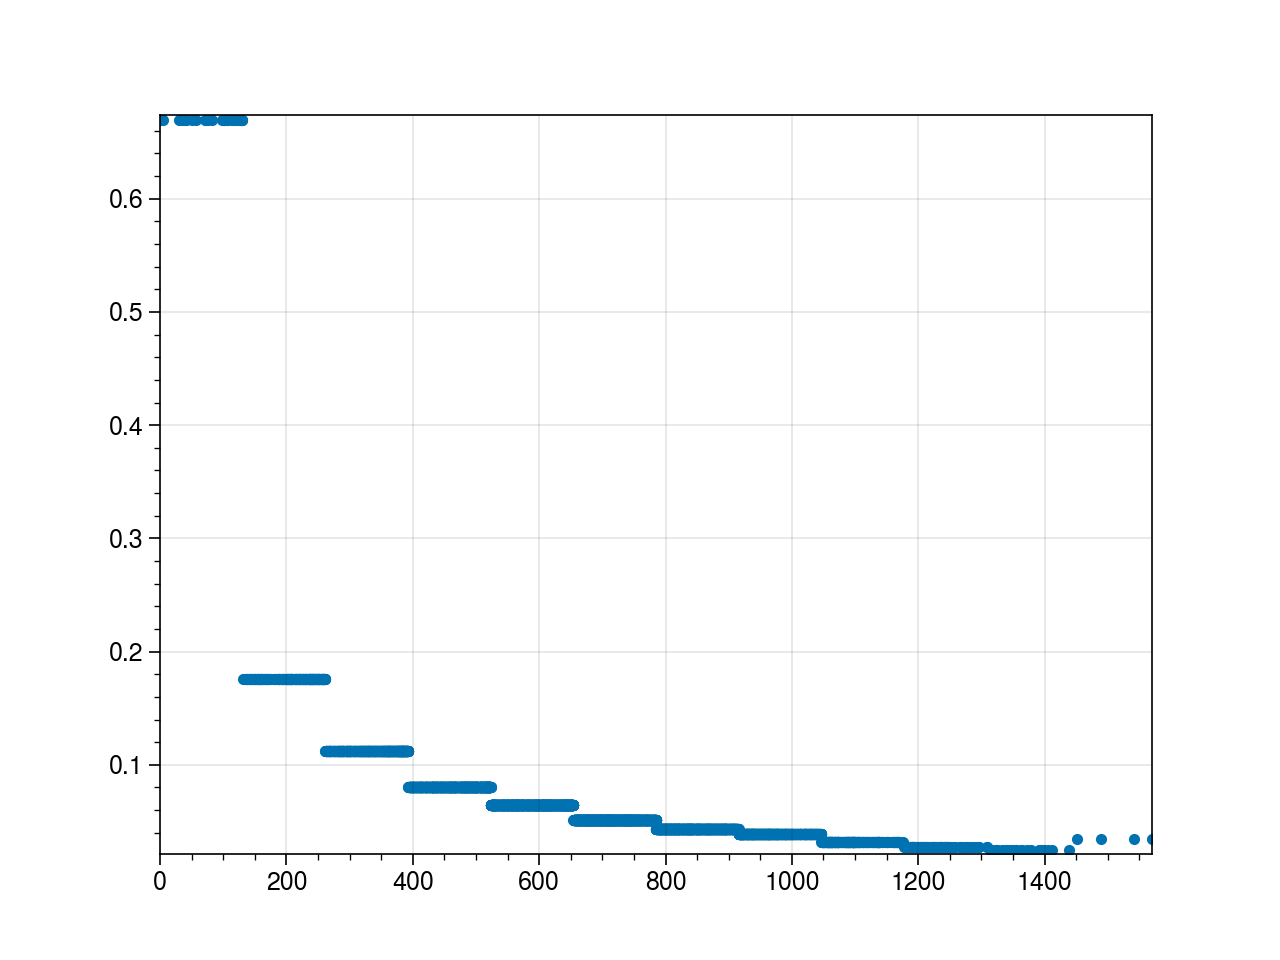

In [20]:
# Plot crop failure as a function of CV

# Can I make this figure but with alphas and lambdas

plt.scatter(df.RF, df.cv_bin)
#plt.ylabel('Yield') # Yield normalized by max. yield
#plt.xlabel('CV')

## Old method for calculating lambdas

## How do simulated totals for MAM compare to empirical values? <a id='MAM_Jacobson'></a>

We'll start with Jacobson Farm (80 years worth of data) for MAM season.

In [ ]:
# Import some data rather than re-running

# MAM rainfall data from Jacobson Farm
rf_mam = pd.read_csv('../output/3-cv-translation/rf_empirical.csv',sep=',').set_index('Year'); rf_mam

# MAM rainfall totals from three eras, including average - These looks like yearly totals, not seasonal....
r0 = pd.read_csv('../output/3-cv-translation/rf_sims_1930s.csv',sep=',').drop(['Unnamed: 0'], axis=1); r0
r1 = pd.read_csv('../output/3-cv-translation/rf_sims_avg.csv',sep=',').drop(['Unnamed: 0'], axis=1)
r2 = pd.read_csv('../output/3-cv-translation/rf_sims_2010s.csv',sep=',').drop(['Unnamed: 0'], axis=1)

In [ ]:
def seasonal_rf(station = None, data_file = None, months = None, xlab = None):
    """ Takes simulation data and empirical data and compares the distributions of MAM seasonal rainfall.
    Returns a plot. 
    
    Usage:
        seasonal_rf(rf, months, xlab)
        
        rf = rf # DataFrame of daily rainfall 
        months = ['3','4','5'] # List of months to subset
        xlab = 'MAM Rainfall (mm)' # String for x-axis label
        
    """
    rf = grab_rf_data(station=station, data_file=data_file)
    rf_ = rf.loc[rf['Month'].isin(months)]
    rf_ = rf_.groupby(['Year'])[station].sum().to_frame()

    # Then seperate into first 40 years, last 40 years
    len(rf_[rf_.index > 1974]) # 40
    len(rf_[rf_.index < 1974]) # 40

    # Distributions of MAM rainfall
    # Plot simulation data
    sns.kdeplot(r0['mam_RF'], color='blue',label="Simulations: 1930s") # can change bandwith to see how tightly estimation fits the data
    sns.kdeplot(r1['mam_RF'], color='orange',label="Simulations: avg.") # bw=.2
    sns.kdeplot(r2['mam_RF'], color='green', label="Simulations: 2010s")
    # Plot empirical data, note: This creates the same plot as using rf_mam. Best to stick with one probably.
    sns.kdeplot(rf_[rf_.index < 1974][station], color='blue',label="Empirical: 1934-1973", linestyle=":") # bw=.2
    sns.kdeplot(rf_[station], label="Empirical: avg.", color='orange',linestyle=":") # can change bandwith to see how tightly estimation fits the data
    sns.kdeplot(rf_[rf_.index > 1974][station], color='green',label="Empirical: 1975-2014", linestyle=":")
    
    plt.legend();
    plt.ylabel('PDF')
    plt.xlabel(xlab)
    
seasonal_rf(station='JACOBSON FARM', data_file = "../data/CETRAD/CETRAD_rainfall.csv", months = ['3','4','5'], xlab='MAM Rainfall (mm)')

# Table of means

table = pd.DataFrame({
                   # 'Rainfall Climatology':['1935-1940','1972-1977','2010-2015']
            'Source':['Simulations','Simulations','Simulations','Empirical','Empirical','Empirical'],
        'Rainfall Era':['1930s','Avg.','2010s',
                        '1934-1973','Avg.','1975-2014'],
            'Average':[r0['mam_RF'].mean(),r1['mam_RF'].mean(),r2['mam_RF'].mean(),
                       rf_mam[rf_mam.index < 1974]['JACOBSON FARM'].mean(),
                       rf_mam['JACOBSON FARM'].mean(),
                       rf_mam[rf_mam.index > 1974]['JACOBSON FARM'].mean()],
            'Standard Deviation':[r0['mam_RF'].std(),r1['mam_RF'].std(),r2['mam_RF'].std(),
                       rf_mam[rf_mam.index < 1974]['JACOBSON FARM'].std(),rf_mam['JACOBSON FARM'].std(),
                       rf_mam[rf_mam.index > 1974]['JACOBSON FARM'].std()],
            'No. in Sample':[len(r0['mam_RF']),len(r1['mam_RF']),len(r2['mam_RF']),
                       len(rf_mam[rf_mam.index < 1974]['JACOBSON FARM']) ,
                       len(rf_mam['JACOBSON FARM']),
                       len(rf_mam[rf_mam.index > 1974]['JACOBSON FARM'])]})

table

For simplicity, let's just look at the average simulation for MAM (orange line) against average empirical MAM (dotted line). Sample size will still be off:

In [ ]:
sns.distplot(r1['mam_RF'], color='blue', label="Simulations MAM") 
sns.distplot(rf_mam['JACOBSON FARM'], color='orange', label="Empirical MAM") 
plt.ylabel('PDF')
plt.xlabel('MAM rainfall, mm')
plt.legend();

table = pd.DataFrame({
            'Source':['Simulations','Empirical'],
            'Average':[r1['mam_RF'].mean(), rf_mam['JACOBSON FARM'].mean()],
            'Standard Deviation':[r1['mam_RF'].std(),
                       rf_mam['JACOBSON FARM'].std()],
            'CV':[r1['mam_RF'].std()/r1['mam_RF'].mean(),
                       rf_mam['JACOBSON FARM'].std()/rf_mam['JACOBSON FARM'].mean()],
            'No. in Sample':[len(r1['mam_RF']),
                       len(rf_mam['JACOBSON FARM'])]})

table

We need to sample 80 seasons from 10,000 seasons to get one realization of the model data that can be compared with the empirical data.

Let's check the length the Jacobson Farm data and set this as a variable for the number of years we want to sample from the simulations data:

In [ ]:
n_sample = len(rf_mam); print(n_sample)

In [ ]:
# Let's take a sample of `n_sample` size from the simulation data
samp = r1.RF.sample(n=n_sample).values

# Then compare the coefficient of variation between the two
print('this is the C.V. of the model output',samp.std()/samp.mean())

print('this is the C.V. of the empirical data',rf_mam['JACOBSON FARM'].std()/rf_mam['JACOBSON FARM'].mean())

In [ ]:
# Run thise 1k times and see if the values converge

# should be able to do this in in a list comprehension
n = 1000
sigma = r1.RF.sample(n=n_sample).std()
mu = r1.RF.sample(n=n_sample).mean()

cvs = [r1.RF.sample(n=n_sample).std()
       /r1.RF.sample(n=n_sample).mean() for n in range(n)]

What we want to know: Given the sample variability in C.V. (0.10 to 0.24) from the simulations, is it close enough to the C.V. we from the empirical data?

In [ ]:
plot_cvs(cvs=cvs)